<div align="center">

# Laboratorio 2 - Deep Learning  
### *Universidad del Valle de Guatemala*

**Sofía García** (22210)  
**Julio García Salas** (22076)  
**Joaquín Campos** (22155)  

</div>

---

## Ejercicio 1

Utilice los conjuntos de **entrenamiento** y **prueba** de **dos** de las series utilizadas en el laboratorio anterior (Laboratorio 1).


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
imp = (pd.read_csv('importaciones_combustibles.csv', parse_dates=['Fecha'])
         .set_index('Fecha')
         .sort_index())

con = (pd.read_csv('consumos_combustibles.csv', parse_dates=['Fecha'])
         .set_index('Fecha')
         .sort_index())
imp = imp.asfreq('MS')
con = con.asfreq('MS')
y_imp_reg  = imp['Gasolina regular']
y_con_reg  = con['Gasolina regular']
def preparar_serie_log(s):
    s = s.replace(0, np.nan).dropna()
    return np.log(s)

log_imp_reg = preparar_serie_log(y_imp_reg)
log_con_reg = preparar_serie_log(y_con_reg)
def split_last_36(log_series):
    train = log_series.iloc[:-36]
    test  = log_series.iloc[-36:]
    return train, test

train_imp_reg, test_imp_reg = split_last_36(log_imp_reg)
train_con_reg, test_con_reg = split_last_36(log_con_reg)
def resumen(nombre, train, test):
    print(f"\n=== {nombre} ===")
    print(f"Train: {train.index.min().date()} → {train.index.max().date()}  | n = {len(train)}")
    print(f"Test : {test.index.min().date()} → {test.index.max().date()}  | n = {len(test)}")

resumen("IMPORTACIÓN Gasolina regular (log)", train_imp_reg, test_imp_reg)
resumen("CONSUMO Gasolina regular (log)",    train_con_reg, test_con_reg)


=== IMPORTACIÓN Gasolina regular (log) ===
Train: 2001-01-01 → 2021-12-01  | n = 252
Test : 2022-01-01 → 2024-12-01  | n = 36

=== CONSUMO Gasolina regular (log) ===
Train: 2000-01-01 → 2021-12-01  | n = 264
Test : 2022-01-01 → 2024-12-01  | n = 36


---

## Ejercicio 2

Cree al menos **dos modelos LSTM** con configuraciones distintas por **cada una** de las series seleccionadas.

In [ ]:
def to_supervised(series, window):
    #series: pd.Series o np.array de 1 columna.
    #Devuelve X (samples, window, 1) y y (samples, ).
    s = np.asarray(series, dtype=np.float32)
    X, y = [], []
    for i in range(len(s) - window):
        X.append(s[i:i+window])
        y.append(s[i+window])
    X = np.array(X)
    y = np.array(y)
    # reshape a [samples, time_steps, features]
    return X.reshape((X.shape[0], X.shape[1], 1)), y

def inverse_log(arr):
    #Invierte np.log(x) -> x.
    return np.exp(arr)

def evaluate_preds(y_true_log, y_pred_log):
    #Métricas en log y en escala original.
    rmse_log  = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mape_log  = mean_absolute_percentage_error(y_true_log, y_pred_log)

    y_true = inverse_log(y_true_log)
    y_pred = inverse_log(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_orig = mean_absolute_percentage_error(y_true, y_pred)

    return {
        "RMSE_log": rmse_log,
        "MAPE_log": mape_log,
        "RMSE_orig": rmse_orig,
        "MAPE_orig": mape_orig
    }

def plot_history(history, title="Loss"):
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.tight_layout()
    plt.show()

WINDOW = 24

def prepare_lstm_data(train_log, test_log, window=WINDOW):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train_log.values.reshape(-1,1)).ravel()
    test_scaled  = scaler.transform(test_log.values.reshape(-1,1)).ravel()
    Xtr, ytr = to_supervised(train_scaled, window)
    Xte, yte = to_supervised(test_scaled,  window)
    y_true_log_test = test_log.values[window:]
    return scaler, Xtr, ytr, Xte, yte, y_true_log_test

def tune_lstm_randomsearch(
    Xtr, ytr, Xte, y_true_log_test, scaler,
    max_trials=15, executions_per_trial=1, epochs=150, patience=15,
    project_name="tuner"
):
    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

    def build_model(hp):
        units1 = hp.Int('units1', 32, 128, step=32, default=64)
        use_stack = hp.Boolean('use_stack', default=False)
        dropout = hp.Float('dropout', 0.0, 0.5, step=0.1, default=0.0)
        lr = hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4], default=1e-3)
        batch_size = hp.Int('batch_size', 16, 128, step=16, default=32)

        model = Sequential()
        if use_stack:
            model.add(LSTM(units1, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])))
            if dropout > 0:
                model.add(Dropout(dropout))
            units2 = hp.Int('units2', 16, 96, step=16, default=32)
            model.add(LSTM(units2))
        else:
            model.add(LSTM(units1, input_shape=(Xtr.shape[1], Xtr.shape[2])))
            if dropout > 0:
                model.add(Dropout(dropout))

        model.add(Dense(1))
        model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
        return model

    tuner = kt.RandomSearch(
        hypermodel=build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='kt_logs',
        project_name=project_name,
        overwrite=True
    )

    tuner.search(
        Xtr, ytr,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[es],
        verbose=0
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    print("== Mejores HP ==")
    for k,v in best_hp.values.items():
        print(f"  {k}: {v}")

    # Reentrenar el mejor modelo
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(
        Xtr, ytr,
        validation_split=0.2,
        epochs=epochs,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es],
        verbose=0
    )

    plot_history(history, title=f"{project_name} - best")

    # Predecir y evaluar
    y_pred_scaled = model.predict(Xte, verbose=0).ravel()
    y_pred_log    = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    metrics = evaluate_preds(y_true_log_test, y_pred_log)
    return model, best_hp, metrics



## Importación Gasolina Regular **(sin tuneo)**

- Modelo A1 (simple): 1 capa LSTM (64) + Dense(1), Adam(1e-3)
- Modelo A2 (stacked + dropout): 2 capas LSTM (64 → 32), dropout=0.2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


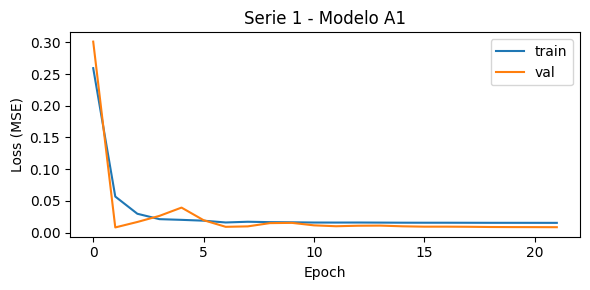

Serie 1 - Modelo A1 (simple):
  RMSE_log: 0.1178
  MAPE_log: 0.0063
  RMSE_orig: 109153.8890
  MAPE_orig: 0.0823


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


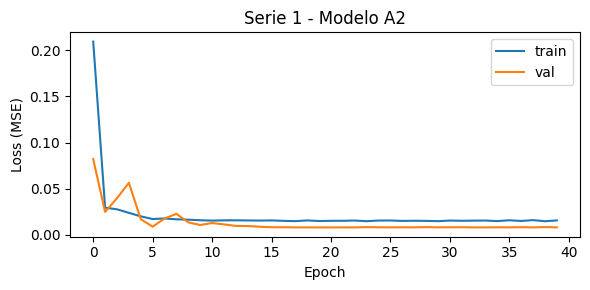


Serie 1 - Modelo A2 (stacked + dropout):
  RMSE_log: 0.1100
  MAPE_log: 0.0061
  RMSE_orig: 101404.1709
  MAPE_orig: 0.0825


In [ ]:
sc_imp, Xtr_imp_A, ytr_imp_A, Xte_imp_A, yte_imp_A, y_true_log_imp = prepare_lstm_data(
    train_imp_reg, test_imp_reg, WINDOW
)

es = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

# Modelo A1
model_A1 = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(1)
])
model_A1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_A1 = model_A1.fit(
    Xtr_imp_A, ytr_imp_A,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

plot_history(hist_A1, "Serie 1 - Modelo A1")

# Predicción (en escala min-max)
y_pred_scaled_A1 = model_A1.predict(Xte_imp_A, verbose=0).ravel()

# Desescalar a log
# Invertimos el MinMaxScaler al espacio original log:
# scaler.inverse_transform espera 2D
y_pred_log_A1 = sc_imp.inverse_transform(y_pred_scaled_A1.reshape(-1,1)).ravel()

metrics_A1 = evaluate_preds(y_true_log_imp, y_pred_log_A1)
print("Serie 1 - Modelo A1 (simple):")
for k,v in metrics_A1.items():
    print(f"  {k}: {v:.4f}")

# Modelo A2
model_A2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model_A2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_A2 = model_A2.fit(
    Xtr_imp_A, ytr_imp_A,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

plot_history(hist_A2, "Serie 1 - Modelo A2")

y_pred_scaled_A2 = model_A2.predict(Xte_imp_A, verbose=0).ravel()
y_pred_log_A2    = sc_imp.inverse_transform(y_pred_scaled_A2.reshape(-1,1)).ravel()

metrics_A2 = evaluate_preds(y_true_log_imp, y_pred_log_A2)
print("\nSerie 1 - Modelo A2 (stacked + dropout):")
for k,v in metrics_A2.items():
    print(f"  {k}: {v:.4f}")

## Consumo Gasolina Regular **(sin tuneo)**
- Modelo B1 (simple): 1 capa LSTM (64) + Dense(1), Adam(1e-3)
- Modelo B2 (stacked + dropout): 2 capas LSTM (64 → 32), dropout=0.2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


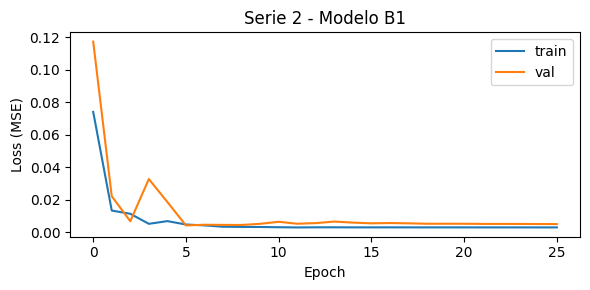

Serie 2 - Modelo B1 (simple):
  RMSE_log: 0.0496
  MAPE_log: 0.0030
  RMSE_orig: 43029.1349
  MAPE_orig: 0.0397


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


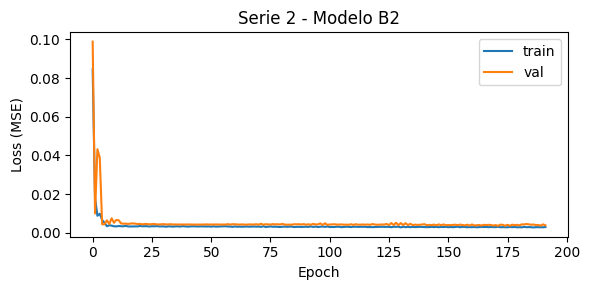


Serie 2 - Modelo B2 (stacked + dropout):
  RMSE_log: 0.0968
  MAPE_log: 0.0062
  RMSE_orig: 81030.4023
  MAPE_orig: 0.0799


In [15]:
sc_con, Xtr_con_B, ytr_con_B, Xte_con_B, yte_con_B, y_true_log_con = prepare_lstm_data(
    train_con_reg, test_con_reg, WINDOW
)

# Modelo B1
model_B1 = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(1)
])
model_B1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_B1 = model_B1.fit(
    Xtr_con_B, ytr_con_B,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)
plot_history(hist_B1, "Serie 2 - Modelo B1")

y_pred_scaled_B1 = model_B1.predict(Xte_con_B, verbose=0).ravel()
y_pred_log_B1    = sc_con.inverse_transform(y_pred_scaled_B1.reshape(-1,1)).ravel()

metrics_B1 = evaluate_preds(y_true_log_con, y_pred_log_B1)
print("Serie 2 - Modelo B1 (simple):")
for k,v in metrics_B1.items():
    print(f"  {k}: {v:.4f}")

# Modelo B2
model_B2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model_B2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_B2 = model_B2.fit(
    Xtr_con_B, ytr_con_B,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)
plot_history(hist_B2, "Serie 2 - Modelo B2")

y_pred_scaled_B2 = model_B2.predict(Xte_con_B, verbose=0).ravel()
y_pred_log_B2    = sc_con.inverse_transform(y_pred_scaled_B2.reshape(-1,1)).ravel()

metrics_B2 = evaluate_preds(y_true_log_con, y_pred_log_B2)
print("\nSerie 2 - Modelo B2 (stacked + dropout):")
for k,v in metrics_B2.items():
    print(f"  {k}: {v:.4f}")